## A more detailed demo of the cluster analysis workflow

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import libpysal as lps
import contextily as ctx

from esda.moran import Moran
from esda.moran import Moran_Local

In [2]:
# Data from example geopackage
fp = './clusters_example_data/example_grid.gpkg'
# Use web mercator for easy contextily mapping
crs = 3857
# Read data to GDF
grid = gpd.read_file(fp)
grid = grid.to_crs(crs)

In [3]:
# Check data
grid.describe()

,population,owner_unique,osm_shops,amenity_count,number_of_stops_sum,avg_d_kbps_mean,5_mean,combined_index
count,201.000000,201.000000,201.000000,201.000000,195.000000,196.000000,176.000000,170.000000
mean,2295.960199,25.492537,23.318408,11.378109,43.841026,105903.722144,446.325093,1.525254
std,1170.738565,59.577690,81.669138,22.218378,47.072333,23002.293072,151.488796,0.707068
min,142.000000,1.000000,1.000000,1.000000,1.000000,39968.000000,63.643215,0.504783
25%,1458.000000,3.000000,2.000000,3.000000,14.000000,92388.075000,347.591940,1.139439
50%,2160.000000,7.000000,5.000000,6.000000,28.000000,105402.025000,486.803618,1.395825
75%,2954.000000,18.000000,15.000000,11.000000,56.500000,120035.425000,589.353362,1.639469
max,5429.000000,517.000000,784.000000,203.000000,347.000000,172204.000000,600.000000,5.398044


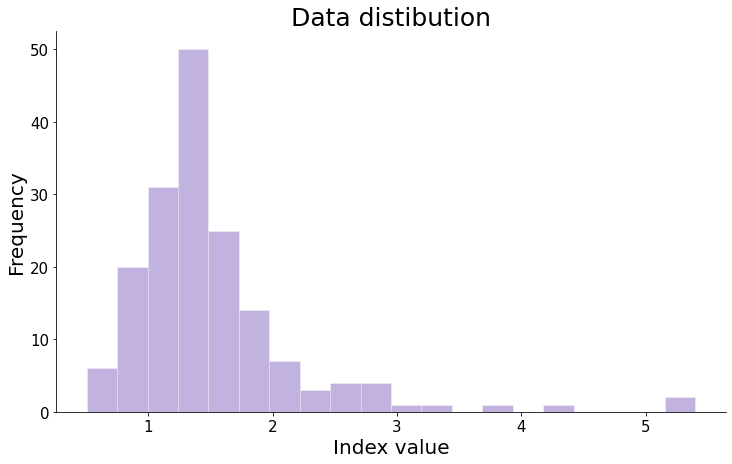

In [4]:
# Visualize data distribution

# Set font sizes
small = 15
medium = 20
large = 25

# Setup plot
fig, ax = plt.subplots(figsize=(12,7))

# Building a histogram
ax.hist(
    x=grid['combined_index'],
    bins=20,
    facecolor=[0.6,0.5,0.8],
    edgecolor=[1,1,1],
    linewidth=0.5,
    alpha=0.6
)

# Customization
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
plt.title('Data distribution', fontsize=large)
plt.xlabel('Index value', fontsize=medium)
plt.ylabel('Frequency', fontsize=medium)
plt.xticks(fontsize=small)
plt.yticks(fontsize=small)
plt.show()

/home/eemil/miniconda3/envs/gis/lib/python3.9/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


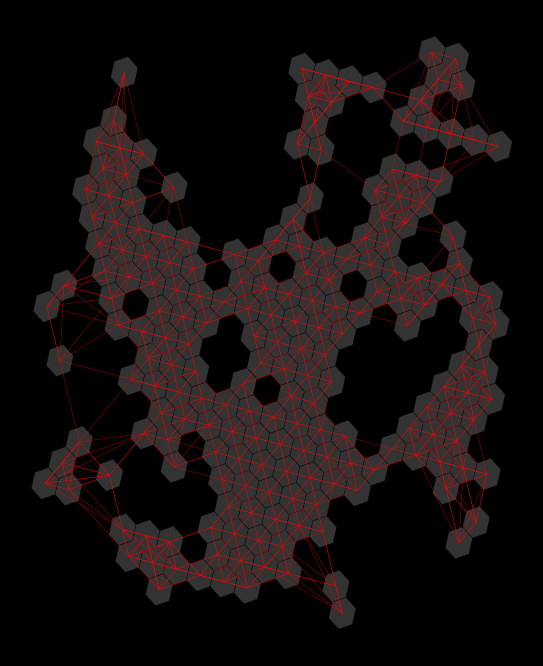

In [18]:
# Create and visualize spatial weights (connectivity within data)

# Use k nearest neighbors, k = 6 since we're dealing with hexagons
weights = lps.weights.KNN.from_dataframe(grid, k=6)

# Draw a knn-contiguity graph of the grid
fig, ax = plt.subplots(figsize=(12, 12), facecolor="black")
grid.plot(ax=ax, facecolor=[0.2,0.2,0.2], edgecolor="black", linewidth=0.3)

# Extract centroids of cells and their neighbors, then draw lines between them
for hexa, neighbors in weights:
    hex_centroid = grid.loc[hexa, 'geometry'].centroid
    for neighbor_centroid in grid.loc[neighbors, 'geometry'].centroid:
        Xs = [hex_centroid.x, neighbor_centroid.x]
        Ys = [hex_centroid.y, neighbor_centroid.y]
        ax.plot(Xs, Ys, color='red', linewidth=0.3)
_ = ax.axis('off')

In [19]:
# Pick which variable we want to analyze
col = 'combined_index'
# Dropna
grid_not_null = grid[[col, 'geometry']].dropna()
y = grid_not_null[col]

# Recompute spatial weights for the new data and then row-standardize
weights = lps.weights.KNN.from_dataframe(grid_not_null, k=6)
weights.set_transform('R')

# compute spatial lag
y_lag = lps.weights.lag_spatial(weights, y)

# Compare cells' values to their neighbors
col_lag = f'{col}_lag'
data_lag = pd.DataFrame(data={col:y, col_lag:y_lag})#.astype(int)
data_lag.head()

/home/eemil/miniconda3/envs/gis/lib/python3.9/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


,combined_index,combined_index_lag
0,0.812844,1.282394
1,1.426001,1.156697
5,1.414373,1.178185
6,1.585597,1.073345
7,0.974449,1.175203


In [20]:
# Calculate Global moran's I and its p-value

# How to interpret Moran's I:
# -1: Perfect clustering of dissimilar values (perfect dispersion)
#  0: No autocorrelation (perfect randomness)
# +1: Perfect clustering of similar values (perfect autocorrelation)

# How to interpret p-value:
# p: the probability of there being no autocorrelation
# Usually p < 0.05 is considered as proof of significant autocorrelation

mi = Moran(data_lag[col], weights)
p_value = mi.p_sim

print("Moran's I:   " + str(mi.I) + '\np-value:     ' + str(p_value))

Moran's I:   0.5565236560749804
p-value:     0.001


In [21]:
# Moran's I tells us whether the data is spatially autocorrelated,
# but it doesn't tell us where this autocorrelation is
# Local indicators of spatial autocorrelation (LISA) reveal this

# Calculate LISA values using the same knn spatial weights
lisa = Moran_Local(data_lag[col], weights, seed=1)

# set the statistical significance threshold (alpha)
# Strict threshold would be 0.05
# This is the value that affects the cluster map
alpha = 0.20

# identify whether each observation is significant or not
# p-value interpretation same as earlier with moran's I
data_lag['significant'] = lisa.p_sim < alpha


# identify the quadrant each observation belongs to
data_lag['quadrant'] = lisa.q
data_lag['quadrant'] = data_lag['quadrant'].replace(
    {1:'HH', 2:'LH', 3:'LL', 4:'HL'}
)
data_lag['quadrant'].sort_values().value_counts()

# Check result
data_lag['significant'].value_counts()

True     93
False    77
Name: significant, dtype: int64

In [22]:
# merge original grid and LISA quadrants data together
gdf_clusters = grid.merge(
    data_lag,
    how='left',
    left_index=True,
    right_index=True
)

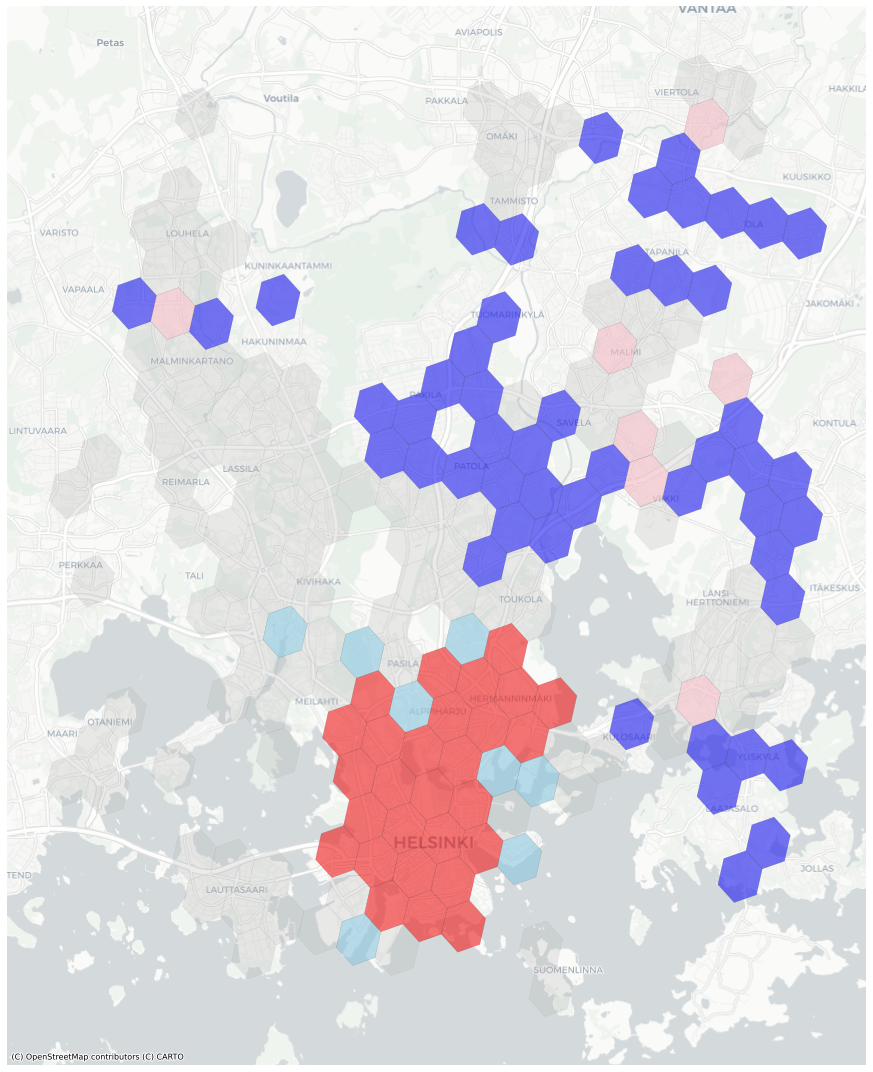

In [23]:
# Plot the local spatial autocorrelation (clusters)
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the complete grid in grey
gdf_clusters.plot(
    ax=ax,
    facecolor=[0.7, 0.7, 0.7],
    edgecolor='black',
    linewidth=0.1,
    alpha=0.25
)

# Plot significant grid cells in their respective colors
quadrant_colors = {'HH':'r', 'LL':'b', 'LH':'skyblue', 'HL':'pink'}
for q, c in quadrant_colors.items():
    mask = gdf_clusters['significant'] & (gdf_clusters['quadrant']==q)
    rows = gdf_clusters.loc[mask]
    rows.plot(ax=ax, color=c, edgecolor='k', linewidth=0.1, alpha=0.5)

ax.axis('off')

# Add basemap
ctx.add_basemap(ax=ax, crs=crs, source=ctx.providers.CartoDB.Positron)

plt.tight_layout()
#plt.savefig('./docs/clusters_' + city + '.png', bbox_inches='tight')

In [24]:
# Result gdf
gdf_clusters

,population,owner_unique,osm_shops,amenity_count,number_of_stops_sum,avg_d_kbps_mean,5_mean,combined_index_x,geometry,combined_index_y,combined_index_lag,significant,quadrant
0,708.0,2,6,4,14.0,86926.750000,600.0,0.812844,"MULTIPOLYGON (((2782124.922 8463689.312, 27827...",0.812844,1.282394,True,LL
1,3829.0,1,8,2,14.0,95109.285714,600.0,1.426001,"MULTIPOLYGON (((2783998.219 8461614.625, 27846...",1.426001,1.156697,True,LL
2,1780.0,1,17,15,16.0,69449.750000,NaN,NaN,"MULTIPOLYGON (((2779177.812 8464471.812, 27798...",NaN,NaN,NaN,NaN
3,1492.0,1,4,2,8.0,NaN,NaN,NaN,"MULTIPOLYGON (((2780651.344 8464080.750, 27812...",NaN,NaN,NaN,NaN
4,2199.0,18,46,25,78.0,100567.555556,NaN,NaN,"MULTIPOLYGON (((2787221.672 8465487.938, 27878...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,3150.0,28,13,26,27.0,91428.500000,NaN,NaN,"MULTIPOLYGON (((2762876.062 8440472.562, 27634...",NaN,NaN,NaN,NaN
197,2142.0,1,2,6,21.0,107014.666667,NaN,NaN,"MULTIPOLYGON (((2761811.094 8439184.438, 27624...",NaN,NaN,NaN,NaN
198,2930.0,1,6,7,40.0,93562.538462,NaN,NaN,"MULTIPOLYGON (((2761928.406 8450146.062, 27625...",NaN,NaN,NaN,NaN
199,1386.0,1,2,2,9.0,105551.230769,NaN,NaN,"MULTIPOLYGON (((2762994.938 8451436.500, 27636...",NaN,NaN,NaN,NaN
